# Лабораторная работа 1: Машина опорных векторов (SVM)

## Брасалес Сарасбати                                  НПМбд-01-22

## 1. Квадратичное программирование и QP-солвер
1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [35]:
import cvxopt
import numpy 
P = matrix(numpy.diag([2,8]), tc='d')
q = matrix(numpy.array([-8,-16]), tc='d')
G = matrix(numpy.array([[1,1],[-1,0],[1,0],[0,-1]]), tc='d')
h = matrix(numpy.array([5,0,3,0]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)

In [36]:
print(sol['x']) 
print(sol['primal objective'])
print(P)
print(q)
print(G)
print(h)


[ 3.00e+00]
[ 2.00e+00]

-30.99999280553902
[ 2.00e+00  0.00e+00]
[ 0.00e+00  8.00e+00]

[-8.00e+00]
[-1.60e+01]

[ 1.00e+00  1.00e+00]
[-1.00e+00  0.00e+00]
[ 1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]

[ 5.00e+00]
[ 0.00e+00]
[ 3.00e+00]
[ 0.00e+00]



Активные ограничения:x_1 + x_2 <= 5, x1<= 3

## 2. Линейный SVM

In [50]:
import numpy as np
from cvxopt import solvers, matrix
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.

In [191]:
class LinearSVM:
    def __init__(self, C):
        self.C = C
        
    def fit(self, X, y):
        n, d = X.shape
        y = np.where(y == 0, -1, 1)  
        
        P = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                P[i, j] = y[i] * y[j] * np.dot(X[i, :], X[j, :])
    
        P = matrix(P)
        q = matrix(-np.ones(n))
        G = matrix(np.vstack((-np.eye(n), np.eye(n))))
        h = matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))
        A = matrix(y.reshape(1, -1), (1, n), 'd')
        b = matrix(np.array([0]), (1, 1), 'd')
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        
        lambdas = np.ravel(solution['x'])  
        support_vector_indices = lambdas > 1e-6
        support_vectors = X[support_vector_indices]  
        support_y = y[support_vector_indices] 
        support_lambdas = lambdas[support_vector_indices] 
        
        self.weights_ = np.sum(support_lambdas[:, None] * support_y[:, None] * support_vectors, axis=0)   
        self.bias_ = np.mean([y_i - np.dot(self.weights_, x_i) for x_i, y_i in zip(support_vectors, support_y)])
        self.support_vectors_ = support_vectors
        self.support_y_ = support_y
        
    def predict_proba(self, X):   
        return np.dot(X, self.weights_) + self.bias_
    
    def predict(self, X): 
        return np.sign(self.predict_proba(X))

2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам

In [192]:
X1, y1 = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, class_sep=2, random_state=1)
X2, y2 = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, class_sep=0.5, random_state=2)
X3, y3 = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, class_sep=0.2, random_state=3)

3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
4. Как зависит число опорных векторов от параметра $C$ для различных выборок?

In [193]:
def plot_svm(X, y, model, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='k')
    
    xvals = np.linspace(-4, 4, 200)
    yvals = np.linspace(-4, 4, 200)
    
    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

    ax.pcolormesh(xx, yy, zz, cmap='autumn', shading='auto', zorder=0)
    ax.contour(xx, yy, zz, levels=[-1, 0, 1], colors=['blue', 'black', 'blue'], linestyles=['--', '-', '--'], linewidths=2, zorder=1)

    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')
    
    
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_title(title)

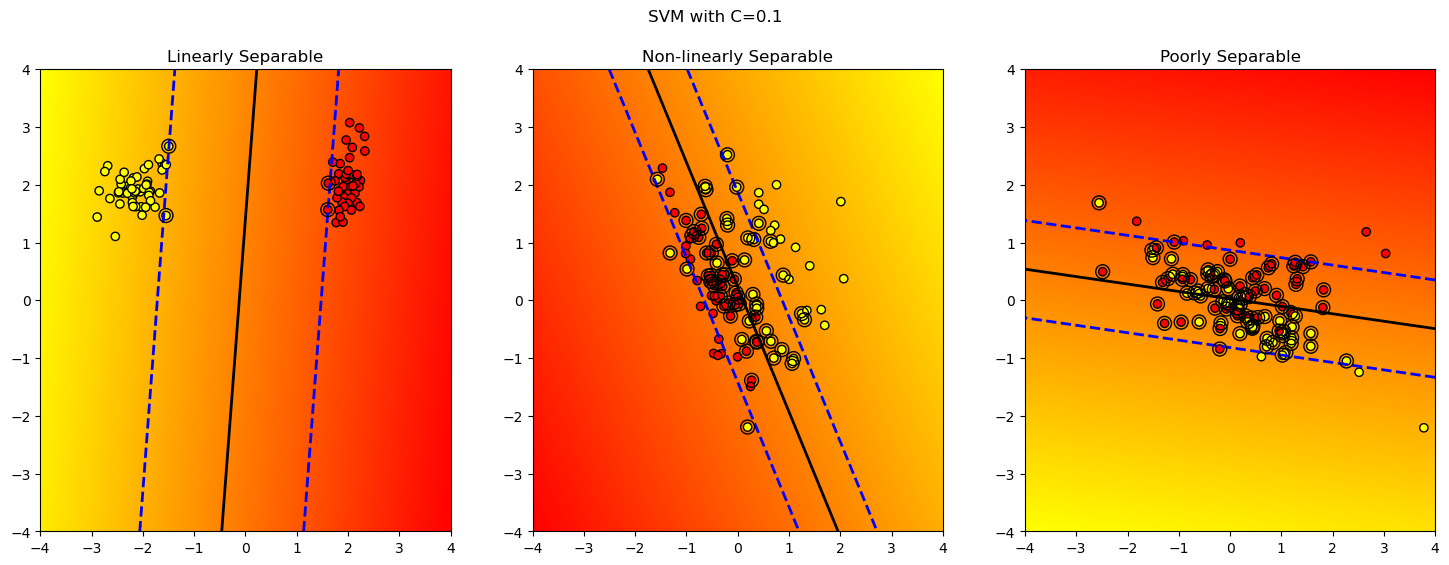

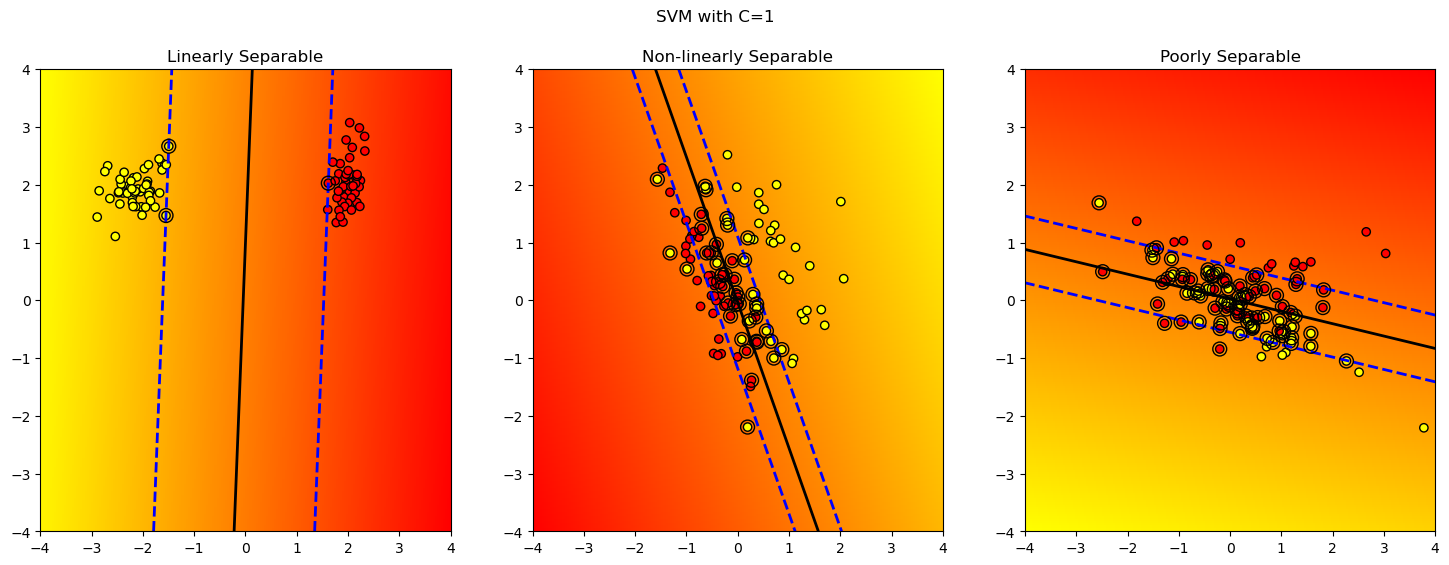

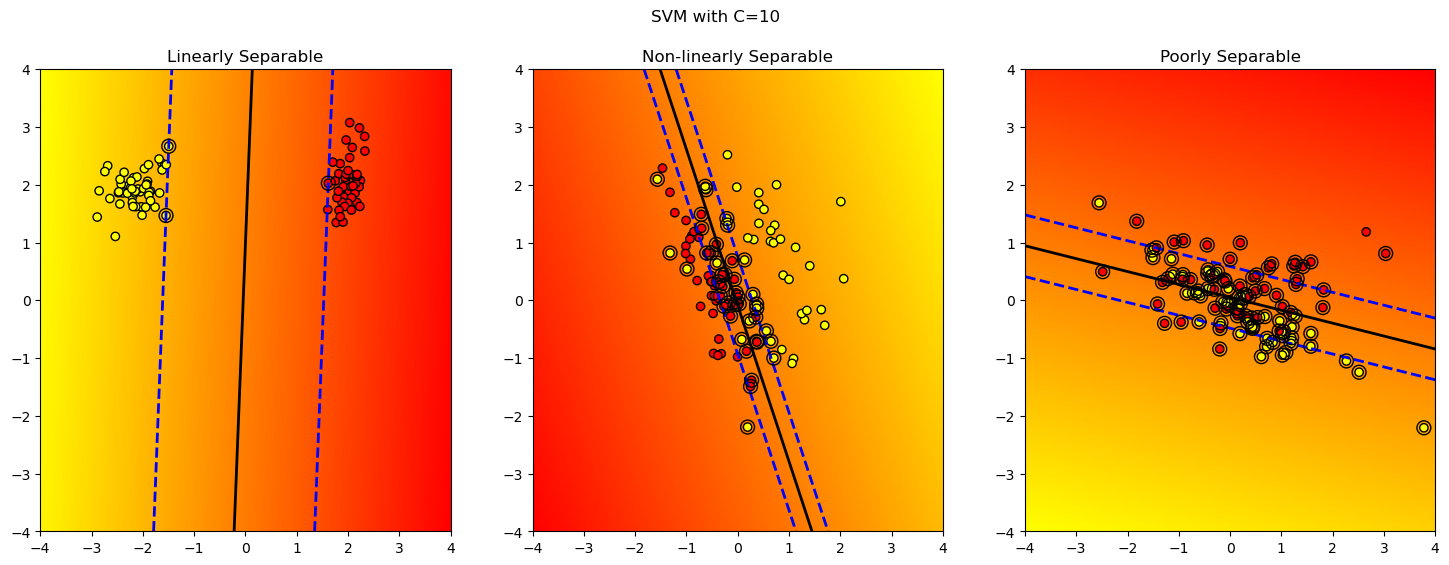

In [194]:
datasets = [(X1, y1, "Linearly Separable"), (X2, y2, "Non-linearly Separable"), (X3, y3, "Poorly Separable")]
C_values = [0.1, 1, 10]

for C in C_values:
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'SVM with C={C}')
    
    for idx, (X, y, title) in enumerate(datasets):
        model = LinearSVM(C=C)
        model.fit(X, y)
        plot_svm(X, y, model, axs[idx], title)
    
    plt.show()

#### Чем меньше параметр C, тем больше будет векторов опоры, что означает, что мы позволим себе больше ошибок.

# 3. Двойственный переход и Ядровой SVM

1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.

In [195]:
class KernelSVM:
    def __init__(self, C, kernel='linear', p=3, gamma=0.5):
        self.C = C
        self.kernel = kernel
        self.p = p
        self.gamma = gamma
        
    def compute_kernel(self, X, X_prime):
        if self.kernel == 'linear':
            return np.dot(X, X_prime.T)
        elif self.kernel == 'polynomial':
            return (np.dot(X, X_prime.T) + 1) ** self.p
        elif self.kernel == 'rbf':
            dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X_prime**2, axis=1) - 2 * np.dot(X, X_prime.T)
            return np.exp(-self.gamma * dists)
    
    def fit(self, X, y):
        n, d = X.shape
        y = y.astype(float)
        
        K = self.compute_kernel(X, X)
        
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n))
        G = matrix(np.vstack((-np.eye(n), np.eye(n))))
        h = matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))
        A = matrix(y, (1, n), 'd')
        b = matrix(0.0)
        
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        
        lambdas = np.ravel(solution['x'])
        support_indices = lambdas > 1e-5
        self.lambdas = lambdas[support_indices]
        self.support_vectors = X[support_indices]
        self.support_y = y[support_indices]
        
        self.bias = np.mean([y_k - np.sum(self.lambdas * self.support_y * K[i, support_indices]) 
                             for i, y_k in enumerate(self.support_y)])
        
    
    def predict_proba(self, X):
        K = self.compute_kernel(X, self.support_vectors)
        return np.sum(self.lambdas * self.support_y * K, axis=1) + self.bias
    
    def predict(self, X):
        return np.sign(self.predict_proba(X))

2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?

In [196]:
def plot_svm(X, y, model, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    X_plot = np.c_[xx.ravel(), yy.ravel()]
    
    Z = model.predict_proba(X_plot).reshape(xx.shape)
    
    ax.pcolormesh(xx, yy, Z, cmap='autumn', shading='auto', zorder=0)
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'blue'], linestyles=['--', '-', '--'], linewidths=2, zorder=1)
    
    ax.scatter(model.support_vectors[:, 0], model.support_vectors[:, 1],
               s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', s=30, edgecolors='k')
    ax.set_title(title)

In [197]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, class_sep=1.5, random_state=5)
y = np.where(y == 0, -1, 1)

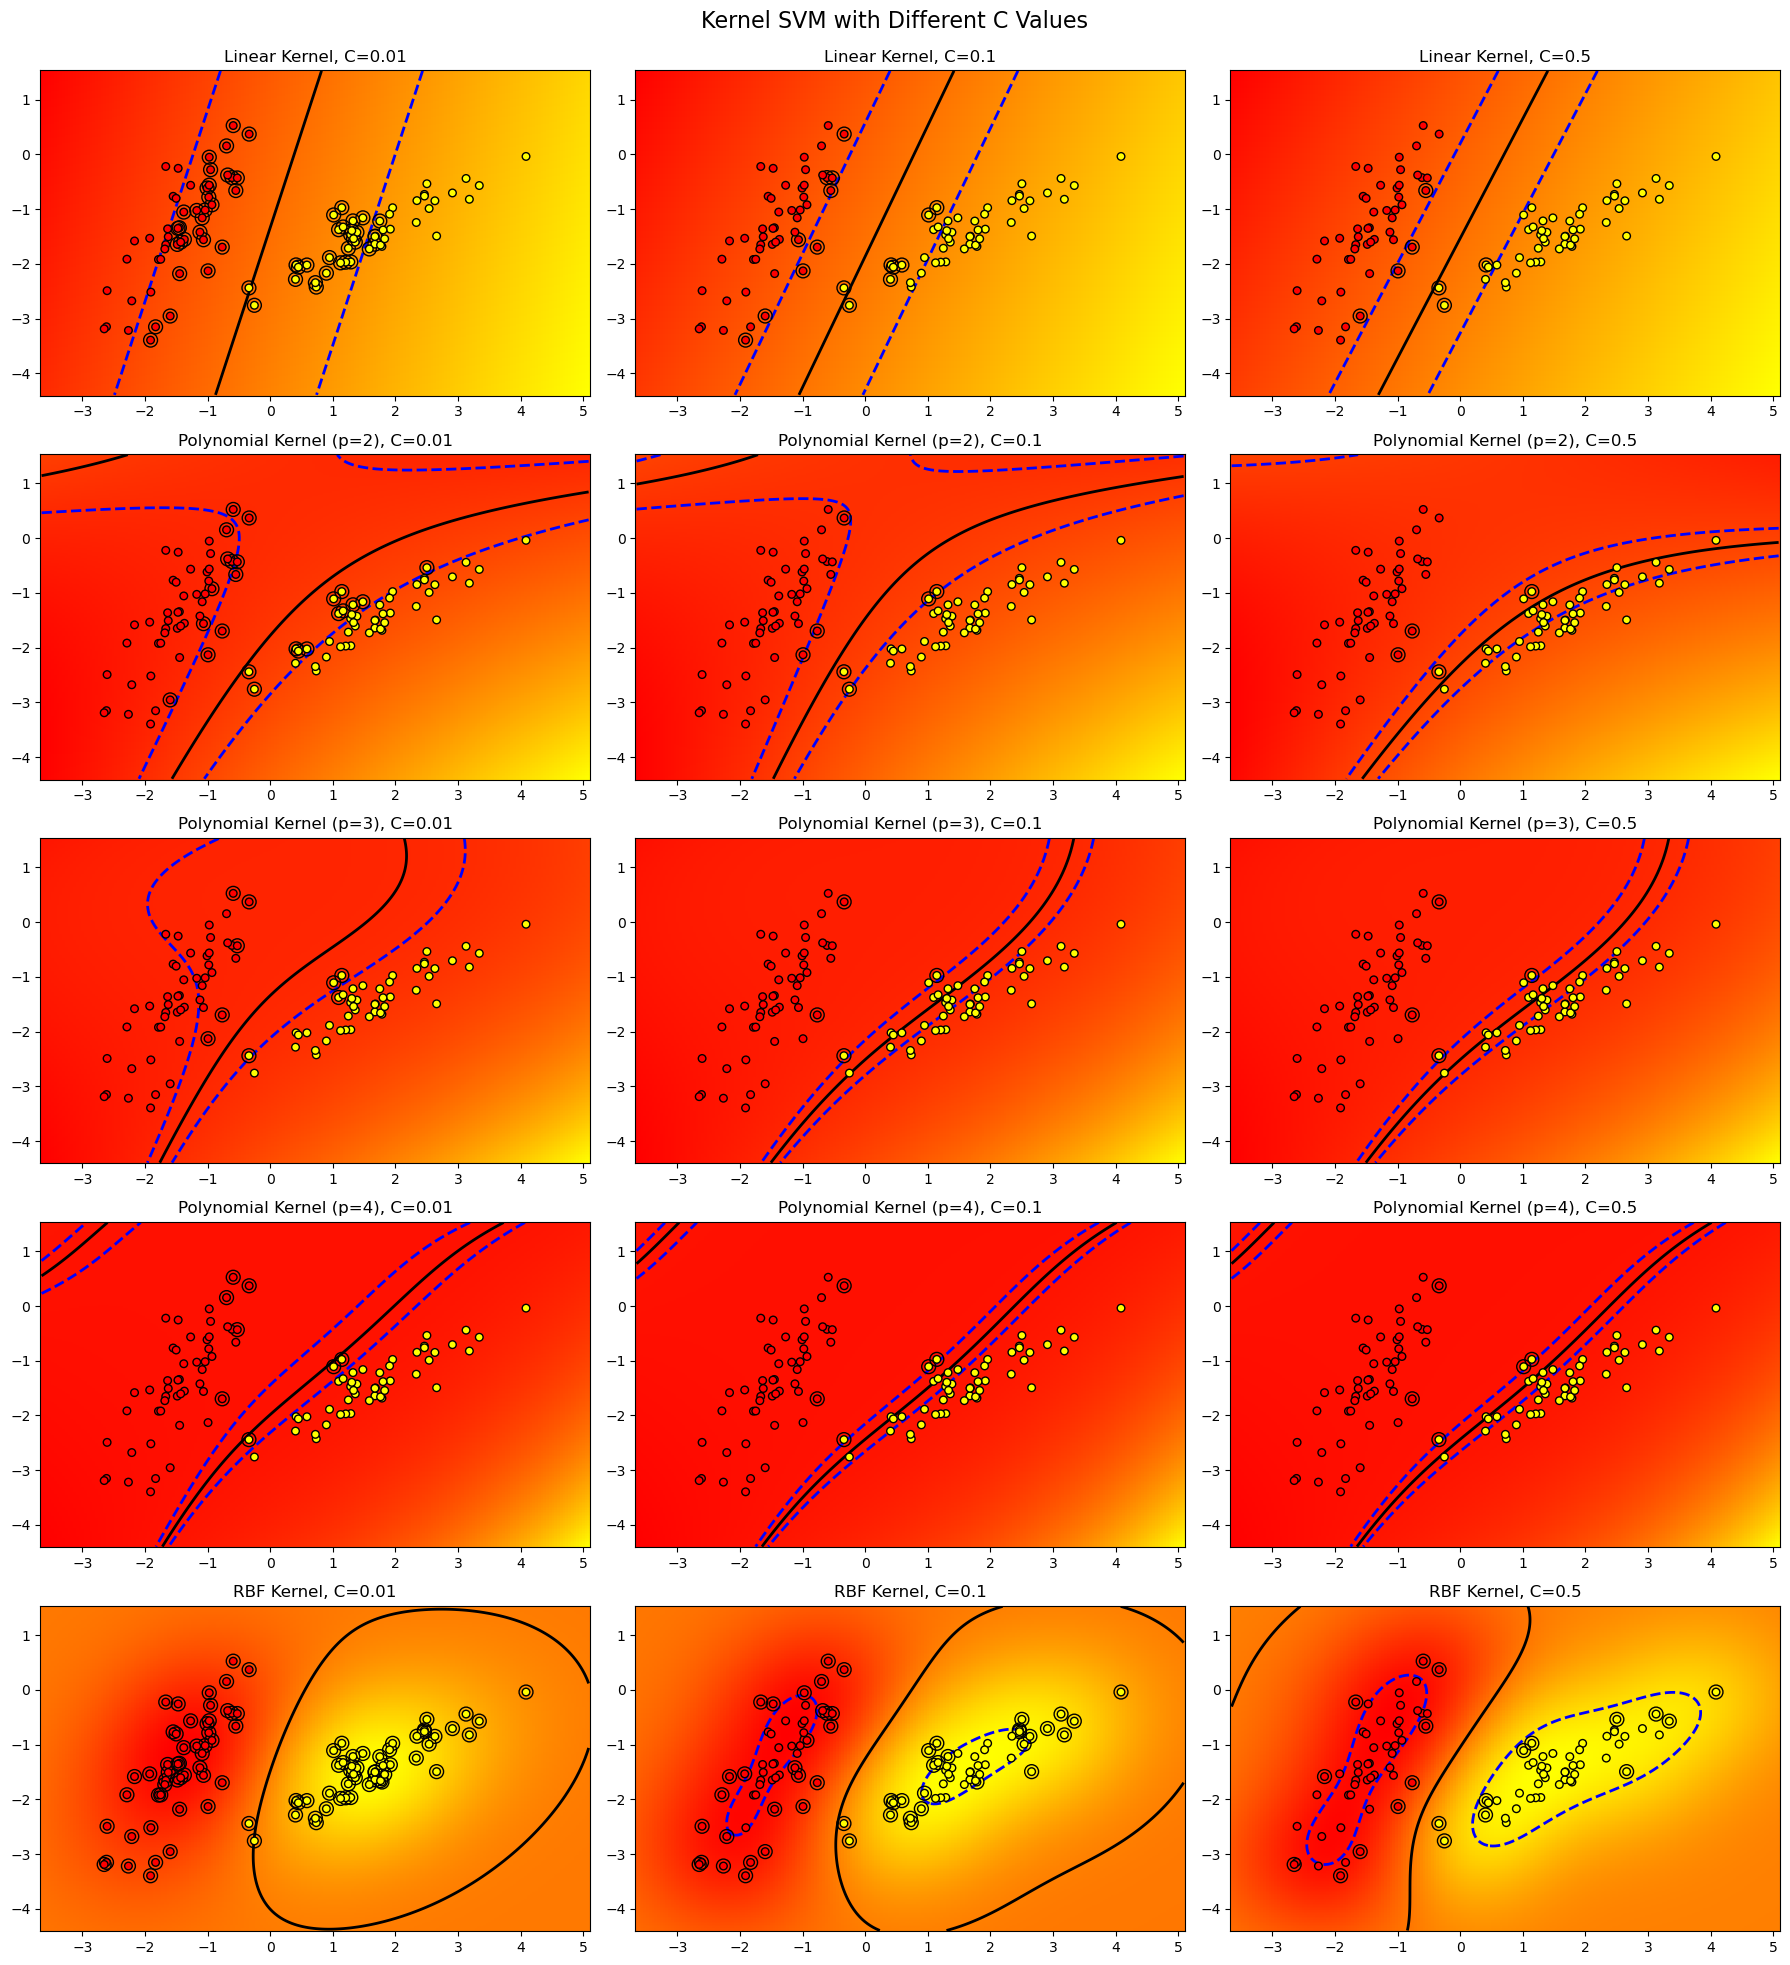

In [198]:
C_values = [0.01, 0.1, 0.5]
kernels = ['linear', 'polynomial', 'rbf']
p_values = [2, 3, 4]  

fig, axs = plt.subplots(5, len(C_values), figsize=(18, 20))
fig.suptitle('Kernel SVM with Different C Values', fontsize=16)

for i, C in enumerate(C_values):
    
    model = KernelSVM(C=C, kernel='linear')
    model.fit(X, y)
    plot_svm(X, y, model, axs[0, i], f'Linear Kernel, C={C}')
    
    model = KernelSVM(C=C, kernel='polynomial', p=2)
    model.fit(X, y)
    plot_svm(X, y, model, axs[1, i], f'Polynomial Kernel (p=2), C={C}')
    
    model = KernelSVM(C=C, kernel='polynomial', p=3)
    model.fit(X, y)
    plot_svm(X, y, model, axs[2, i], f'Polynomial Kernel (p=3), C={C}')
    
    model = KernelSVM(C=C, kernel='polynomial', p=4)
    model.fit(X, y)
    plot_svm(X, y, model, axs[3, i], f'Polynomial Kernel (p=4), C={C}')
    
    model = KernelSVM(C=C, kernel='rbf', gamma=0.5)
    model.fit(X, y)
    plot_svm(X, y, model, axs[4, i], f'RBF Kernel, C={C}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

#### В результате мы получаем кривые второго, третьего и четвертого порядка.

4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

In [ ]:
def kernel_rbf(X, X_prime, gamma):
    dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X_prime**2, axis=1) - 2 * np.dot(X, X_prime.T)
    return np.exp(-0.5 * gamma * dists)

In [187]:
def plot_svm_rbf(X, y, model, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    ax.pcolormesh(xx, yy, Z, cmap='autumn', shading='auto', zorder=0)
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'blue'], linestyles=['--', '-', '--'], linewidths=2, zorder=1)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', s=30, edgecolors='k')
    ax.set_title(title)



In [189]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, class_sep=1.5, random_state=5)
y = np.where(y == 0, -1, 1)

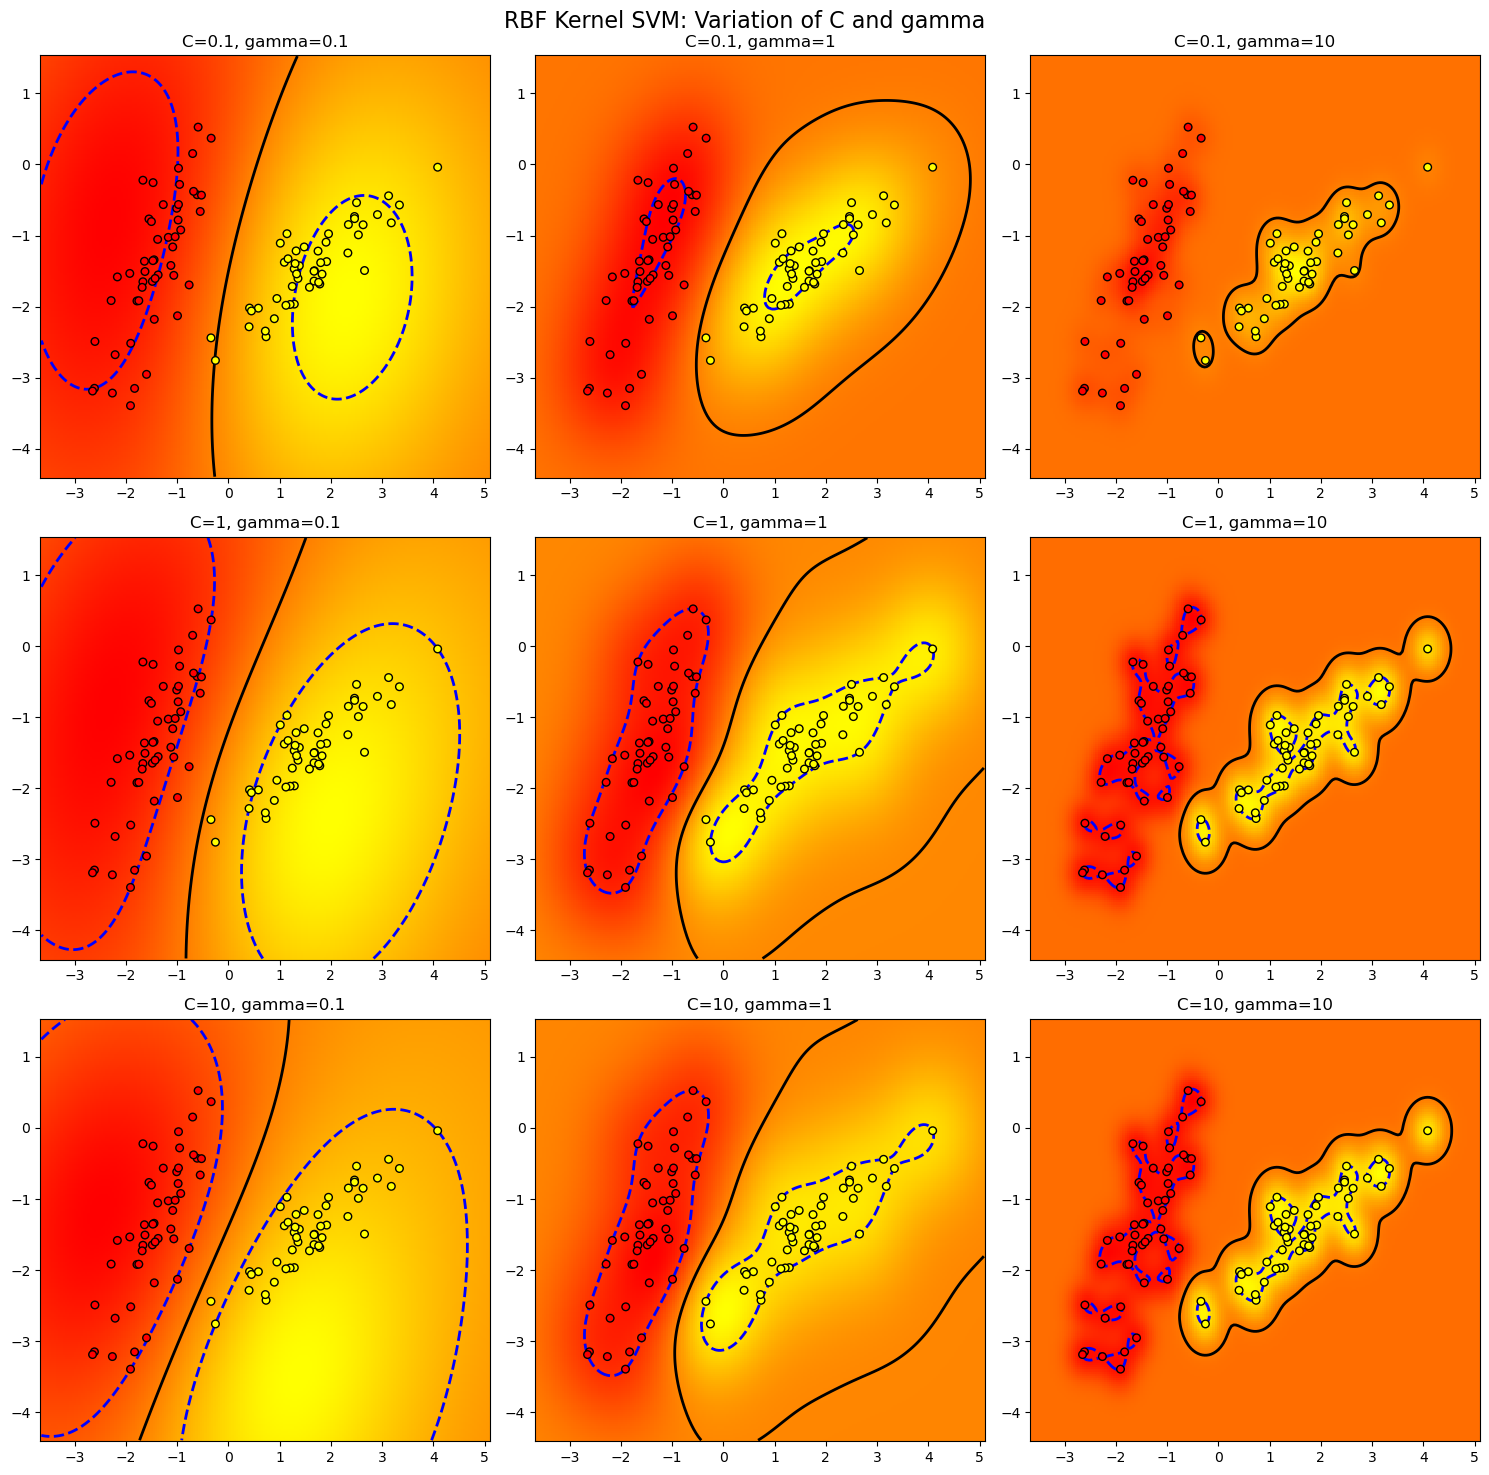

In [190]:
C_values = [0.1, 1, 10]
gamma_values = [0.1, 1, 10]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('RBF Kernel SVM: Variation of C and gamma', fontsize=16)

for i, C in enumerate(C_values):
    for j, gamma in enumerate(gamma_values):
        
        model = SVC(C=C, kernel='rbf', gamma=gamma)
        model.fit(X, y)
        plot_svm_rbf(X, y, model, axs[i, j], f'C={C}, gamma={gamma}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


Параметр C:
Высокие значения C: Модель пытается минимизировать ошибку на обучающем наборе данных, что может привести к переобучению (overfitting). При этом модель будет следовать за каждым примером данных, создавая сложные границы между классами.
Низкие значения C: Модель допускает ошибки на обучающем наборе данных, что может привести к слишком грубой модели (underfitting). В этом случае модель будет более простой и не будет хорошо соответствовать данным.
Параметр γ:
Высокие значения γ: Ядро RBF становится более узким, что позволяет модели фокусироваться на ближайших точках данных и может привести к переобучению, если 
γ слишком велико.
Низкие значения γ: Ядро RBF становится более широким, что может привести к слишком грубой модели, поскольку границы решений будут более сглаженными.